# Recommendation System Analysis

This notebook analyzes the recommendation outputs from different models, examining:
1. User segmentation by recommendation quality (bad/medium/good)
2. Qualitative analysis of individual users
3. User embedding similarity to historical interactions

In [1]:
# Configuration
DATASET = 'steam'  # Change to 'amazon' or 'yelp' as needed
MODEL = 'lightgcn_plus'  # Change to other model names as needed

In [2]:
!uv pip install pandas matplotlib seaborn scikit-learn

Audited 4 packages in 5ms


In [3]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Configuration

In [4]:
# Paths
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'data' / DATASET
EXPORT_DIR = BASE_DIR / 'encoder' / 'exports'
PROFILE_EXPORT_DIR = BASE_DIR / 'data' / 'exports'
ANALYSIS_DIR = BASE_DIR / 'analysis' / DATASET / MODEL
os.makedirs(ANALYSIS_DIR, exist_ok=True)

# Files
RECS_FILE = EXPORT_DIR / f'recs_{MODEL}_{DATASET}.csv'
USER_PROFILES_FILE = PROFILE_EXPORT_DIR / f'{DATASET}_user_profiles.csv'
ITEM_PROFILES_FILE = PROFILE_EXPORT_DIR / f'{DATASET}_item_profiles.csv'

# Pickle files
USR_EMB_PKL = DATA_DIR / 'usr_emb_np.pkl'
ITM_EMB_PKL = DATA_DIR / 'itm_emb_np.pkl'
USR_PRF_PKL = DATA_DIR / 'usr_prf.pkl'
ITM_PRF_PKL = DATA_DIR / 'itm_prf.pkl'

print(f"Analyzing: {MODEL} on {DATASET}")
print(f"Recommendations file: {RECS_FILE}")
print(f"Files exist: {RECS_FILE.exists()}")

Analyzing: lightgcn_plus on steam
Recommendations file: encoder/exports/recs_lightgcn_plus_steam.csv
Files exist: True


## Load Data

In [5]:
# Load recommendations CSV
print("Loading recommendations...")
df_recs = pd.read_csv(RECS_FILE)
print(f"Loaded {len(df_recs)} users")

# Load user and item profiles
print("\nLoading profiles...")
df_users = pd.read_csv(USER_PROFILES_FILE)
df_items = pd.read_csv(ITEM_PROFILES_FILE)
print(f"Loaded {len(df_users)} user profiles and {len(df_items)} item profiles")

# Load embeddings
print("\nLoading embeddings...")
with open(USR_EMB_PKL, 'rb') as f:
    usr_emb = pickle.load(f)
with open(ITM_EMB_PKL, 'rb') as f:
    itm_emb = pickle.load(f)
print(f"User embeddings: {usr_emb.shape}, Item embeddings: {itm_emb.shape}")

# Load full profile dictionaries
print("\nLoading profile dictionaries...")
with open(USR_PRF_PKL, 'rb') as f:
    usr_prf_dict = pickle.load(f)
with open(ITM_PRF_PKL, 'rb') as f:
    itm_prf_dict = pickle.load(f)

print("\nData loaded successfully!")
df_recs.head()

Loading recommendations...
Loaded 22345 users

Loading profiles...
Loaded 23310 user profiles and 5237 item profiles

Loading embeddings...
User embeddings: (23310, 1536), Item embeddings: (5237, 1536)

Loading profile dictionaries...
Loaded 23310 user profiles and 5237 item profiles

Loading embeddings...
User embeddings: (23310, 1536), Item embeddings: (5237, 1536)

Loading profile dictionaries...

Data loaded successfully!

Data loaded successfully!


,user_id_int,n_train_interactions,train_item_ids,test_item_ids,topk_item_ids,topk_scores,recall@5,recall@10,recall@20,ndcg@5,ndcg@10,ndcg@20
0,0,65,0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18...,138|141|143|144|146|660|819|820|941|1186|2168|...,111|1328|570|1455|1326|2486|141|130|107|1223|4...,15.129466|14.004256|13.605890|13.451191|13.402...,0.000000,0.052632,0.052632,0.000000,0.073364,0.048929
1,1,20,65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|8...,0|86|147|148|599|1693|1943|4090|4490|4668|4923,205|2779|3359|271|457|150|768|137|553|3035|222...,8.881799|8.854031|8.717054|8.582006|8.523626|8...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,63,9|16|26|37|43|44|48|50|54|59|85|86|87|88|89|90...,77|147|149|150|154|155|159|160|601|663|767|821...,665|670|63|833|669|684|801|1097|62|1308|767|15...,17.277765|17.071321|17.029535|16.154949|16.106...,0.000000,0.000000,0.041667,0.000000,0.000000,0.039621
3,3,496,6|9|13|17|23|24|25|33|40|41|44|45|47|48|54|63|...,0|11|22|30|57|59|75|78|97|99|100|114|123|136|1...,2486|1186|620|1720|1455|798|77|125|1208|16|665...,25.255587|20.463955|19.355772|19.067490|19.060...,0.016043,0.016043,0.021390,0.699215,0.453743,0.328341
4,4,78,2|21|26|52|85|101|107|120|128|135|150|151|172|...,62|111|401|865|957|1081|1363|1412|1421|1582|15...,111|62|59|957|1092|832|941|839|79|1017|1036|87...,21.358341|19.679068|18.276236|15.835947|15.578...,0.230769,0.230769,0.230769,0.699215,0.453743,0.384959


## 1. User Segmentation by Recommendation Quality

Split users into three groups based on Recall@20:
- **Bad**: 0 recall
- **Medium**: Above zero recall, below 75th percentile
- **Good**: Above 75th percentile recall

In [6]:
# Calculate percentiles
recall_col = 'recall@20'
percentile_75 = df_recs[recall_col].quantile(0.75)

print(f"Recall@20 statistics:")
print(f"  Min: {df_recs[recall_col].min():.4f}")
print(f"  25th percentile: {df_recs[recall_col].quantile(0.25):.4f}")
print(f"  Median: {df_recs[recall_col].median():.4f}")
print(f"  75th percentile: {percentile_75:.4f}")
print(f"  Max: {df_recs[recall_col].max():.4f}")
print(f"  Mean: {df_recs[recall_col].mean():.4f}")

# Segment users
def segment_user(recall):
    if recall == 0:
        return 'Bad'
    elif recall <= percentile_75:
        return 'Medium'
    else:
        return 'Good'

df_recs['segment'] = df_recs[recall_col].apply(segment_user)

# Count users in each segment
segment_counts = df_recs['segment'].value_counts()
print(f"\nUser segmentation:")
for segment, count in segment_counts.items():
    pct = 100 * count / len(df_recs)
    print(f"  {segment}: {count} users ({pct:.1f}%)")

Recall@20 statistics:
  Min: 0.0000
  25th percentile: 0.0000
  Median: 0.0000
  75th percentile: 0.2500
  Max: 1.0000
  Mean: 0.1412

User segmentation:
  Bad: 13029 users (58.3%)
  Medium: 4677 users (20.9%)
  Good: 4639 users (20.8%)


### Histogram: Number of Train Interactions by Segment

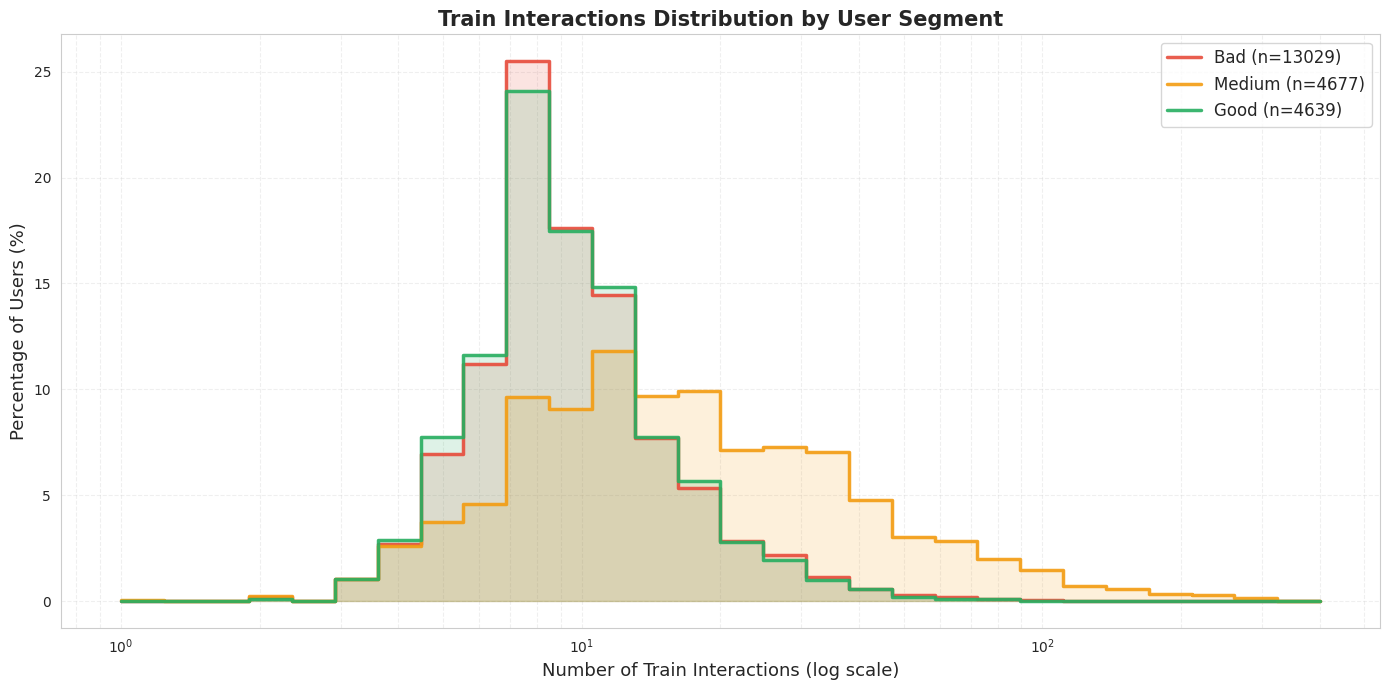


Train Interactions Statistics by Segment:
           count       mean        std  min  25%   50%   75%    max
segment                                                            
Bad      13029.0  10.810423   7.594658  1.0  7.0   9.0  12.0  162.0
Good      4639.0  10.630308   6.936119  2.0  7.0   9.0  12.0  101.0
Medium    4677.0  25.061150  30.512238  1.0  9.0  16.0  29.0  496.0

Segment Statistics:
Bad: Mean=10.8, Median=9.0
Medium: Mean=25.1, Median=16.0
Good: Mean=10.6, Median=9.0


In [7]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

segments = ['Bad', 'Medium', 'Good']
colors = ['#e74c3c', '#f39c12', '#27ae60']

# Determine shared bins based on all data - use log scale bins
all_data = df_recs['n_train_interactions']
bins = np.logspace(np.log10(all_data.min()), np.log10(all_data.max()), 30)

# Plot all three segments with step histograms (clearer than overlapping bars)
for segment, color in zip(segments, colors):
    segment_data = df_recs[df_recs['segment'] == segment]['n_train_interactions']
    # Calculate histogram values
    counts, bin_edges = np.histogram(segment_data, bins=bins)
    # Convert to percentages
    percentages = (counts / len(segment_data)) * 100
    # Plot as step histogram (line style)
    ax.plot(bin_edges[:-1], percentages, drawstyle='steps-post', color=color, 
            linewidth=2.5, label=f'{segment} (n={len(segment_data)})', alpha=0.9)
    # Optionally fill under the curve with transparency
    ax.fill_between(bin_edges[:-1], percentages, step='post', color=color, alpha=0.15)

# Set log scale for x-axis
ax.set_xscale('log')

ax.set_xlabel('Number of Train Interactions (log scale)', fontsize=13)
ax.set_ylabel('Percentage of Users (%)', fontsize=13)
ax.set_title('Train Interactions Distribution by User Segment', fontsize=15, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='both', alpha=0.3, linestyle='--', which='both')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / f'interaction_histogram_{MODEL}_{DATASET}.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics by segment
print("\nTrain Interactions Statistics by Segment:")
print(df_recs.groupby('segment')['n_train_interactions'].describe())

# Print mean and median for each segment
print("\nSegment Statistics:")
for segment in segments:
    segment_data = df_recs[df_recs['segment'] == segment]['n_train_interactions']
    print(f"{segment}: Mean={segment_data.mean():.1f}, Median={segment_data.median():.1f}")

### Overall Distribution

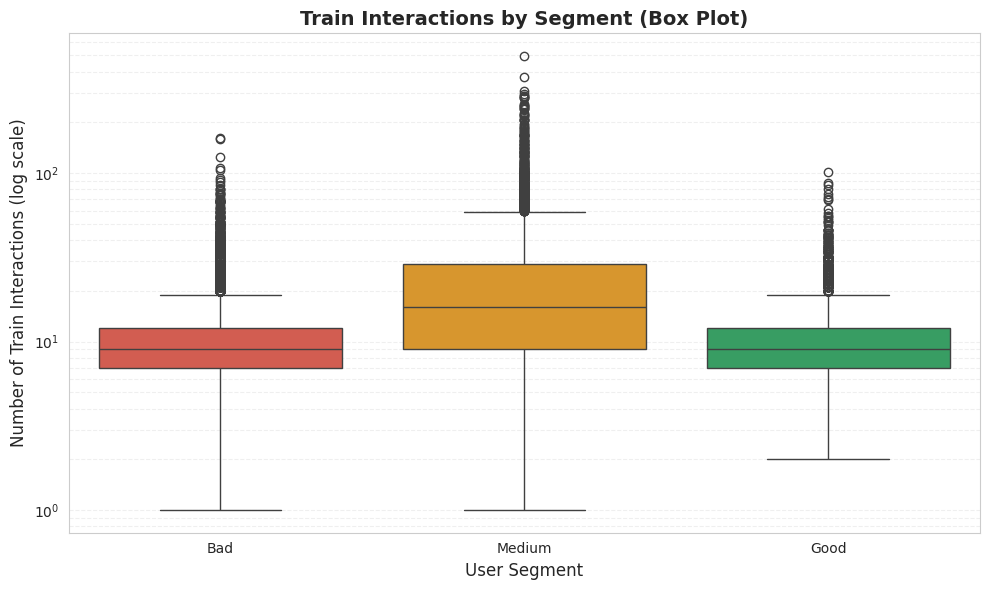

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Box plot
segment_order = ['Bad', 'Medium', 'Good']
sns.boxplot(data=df_recs, x='segment', y='n_train_interactions', order=segment_order, 
            palette={'Bad': colors[0], 'Medium': colors[1], 'Good': colors[2]}, ax=ax)

# Set log scale for y-axis
ax.set_yscale('log')

ax.set_xlabel('User Segment', fontsize=12)
ax.set_ylabel('Number of Train Interactions (log scale)', fontsize=12)
ax.set_title('Train Interactions by Segment (Box Plot)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3, which='both', linestyle='--')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / f'interaction_comparison_{MODEL}_{DATASET}.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Qualitative Analysis: Random User Deep Dive

Select a few random users from each segment and examine:
- User profile information
- All historical interactions (train items)
- Predicted items (recommendations)
- Actual test items (ground truth)

In [9]:
def parse_id_list(id_str):
    """Parse pipe-separated ID string to list of integers."""
    if pd.isna(id_str) or id_str == '':
        return []
    return [int(x) for x in str(id_str).split('|')]

def get_item_profile(item_id_int):
    """Get item profile text by integer ID."""
    match = df_items[df_items['item_id_int'] == item_id_int]
    if len(match) > 0:
        return {
            'item_id_raw': match.iloc[0]['item_id_raw'],
            'profile': match.iloc[0]['profile_text']
        }
    return {'item_id_raw': 'N/A', 'profile': 'Profile not found'}

def get_user_full_profile(user_id_int):
    """Get full user profile from pickle dictionary."""
    if user_id_int in usr_prf_dict:
        return usr_prf_dict[user_id_int]
    return {'profile': 'N/A', 'reasoning': 'N/A'}

def print_user_analysis(user_row):
    """Print comprehensive analysis for a single user."""
    user_id = user_row['user_id_int']
    segment = user_row['segment']
    
    print("="*100)
    print(f"USER ID: {user_id}")
    print(f"Segment: {segment}")
    print(f"Number of train interactions: {user_row['n_train_interactions']}")
    print(f"Recall@20: {user_row['recall@20']:.4f}")
    print(f"NDCG@20: {user_row['ndcg@20']:.4f}")
    print("="*100)
    
    # Get user profile from CSV
    user_profile_csv = df_users[df_users['user_id_int'] == user_id]
    if len(user_profile_csv) > 0:
        print(f"\n{'USER ID (RAW):':<25} {user_profile_csv.iloc[0]['user_id_raw']}")
    
    # Get full user profile from pickle
    user_full_profile = get_user_full_profile(user_id)
    print(f"\n{'USER PROFILE:':<25}")
    print(f"{user_full_profile.get('profile', 'N/A')}")
    print(f"\n{'USER REASONING:':<25}")
    print(f"{user_full_profile.get('reasoning', 'N/A')}")
    
    # Parse item lists
    train_items = parse_id_list(user_row['train_item_ids'])
    test_items = parse_id_list(user_row['test_item_ids'])
    pred_items = parse_id_list(user_row['topk_item_ids'])
    pred_scores = [float(x) for x in str(user_row['topk_scores']).split('|')] if pd.notna(user_row['topk_scores']) else []
    
    # Historical interactions (train items)
    print(f"\n{'-'*100}")
    print(f"HISTORICAL INTERACTIONS (TRAIN): {len(train_items)} items")
    print(f"{'-'*100}")
    for i, item_id in enumerate(train_items[:10], 1):  # Show first 10
        item_info = get_item_profile(item_id)
        print(f"\n[{i}] Item ID: {item_id} (Raw: {item_info['item_id_raw']})")
        print(f"    {item_info['profile'][:200]}..." if len(item_info['profile']) > 200 else f"    {item_info['profile']}")
    
    if len(train_items) > 10:
        print(f"\n... and {len(train_items) - 10} more train items")
    
    # Predicted items (recommendations)
    print(f"\n{'-'*100}")
    print(f"PREDICTED ITEMS (TOP-{len(pred_items)} RECOMMENDATIONS)")
    print(f"{'-'*100}")
    for i, (item_id, score) in enumerate(zip(pred_items[:10], pred_scores[:10]), 1):  # Show top 10
        item_info = get_item_profile(item_id)
        in_test = '✓ HIT' if item_id in test_items else '✗ MISS'
        print(f"\n[{i}] Item ID: {item_id} (Raw: {item_info['item_id_raw']}) | Score: {score:.4f} | {in_test}")
        print(f"    {item_info['profile'][:200]}..." if len(item_info['profile']) > 200 else f"    {item_info['profile']}")
    
    # Actual test items (ground truth)
    print(f"\n{'-'*100}")
    print(f"GROUND TRUTH (TEST ITEMS): {len(test_items)} items")
    print(f"{'-'*100}")
    for i, item_id in enumerate(test_items, 1):
        item_info = get_item_profile(item_id)
        in_pred = '✓ PREDICTED' if item_id in pred_items else '✗ NOT PREDICTED'
        print(f"\n[{i}] Item ID: {item_id} (Raw: {item_info['item_id_raw']}) | {in_pred}")
        print(f"    {item_info['profile'][:200]}..." if len(item_info['profile']) > 200 else f"    {item_info['profile']}")
    
    print("\n" + "="*100 + "\n")

In [10]:
# Select random users from each segment (with more than 20 train interactions)
n_users_per_segment = 2
min_train_interactions = 20
np.random.seed(42)

# Open file to capture output
output_file = ANALYSIS_DIR / f'qualitative_analysis_{MODEL}_{DATASET}.txt'
import sys
from io import StringIO

# Capture stdout
old_stdout = sys.stdout
sys.stdout = StringIO()

for segment in ['Bad', 'Medium', 'Good']:
    # Filter users with more than 20 train interactions
    segment_users = df_recs[(df_recs['segment'] == segment) & (df_recs['n_train_interactions'] > min_train_interactions)]
    if len(segment_users) == 0:
        print(f"No users in {segment} segment with more than {min_train_interactions} interactions")
        continue
    
    sample_size = min(n_users_per_segment, len(segment_users))
    sample_users = segment_users.sample(n=sample_size, random_state=42)
    
    print(f"\n\n{'#'*100}")
    print(f"{'#'*100}")
    print(f"SEGMENT: {segment.upper()}")
    print(f"{'#'*100}")
    print(f"{'#'*100}\n")
    
    for idx, (_, user_row) in enumerate(sample_users.iterrows(), 1):
        print(f"\n>>> Sample {idx}/{sample_size} from {segment} segment <<<\n")
        print_user_analysis(user_row)

# Get captured output
output_text = sys.stdout.getvalue()
sys.stdout = old_stdout

# Print to console
print(output_text)

# Save to file
with open(output_file, 'w', encoding='utf-8') as f:
    f.write(f"Qualitative Analysis: {MODEL} on {DATASET}\n")
    f.write(f"{'='*100}\n\n")
    f.write(output_text)

print(f"\n{'='*100}")
print(f"Qualitative analysis saved to: {output_file}")
print(f"{'='*100}")



####################################################################################################
####################################################################################################
SEGMENT: BAD
####################################################################################################
####################################################################################################


>>> Sample 1/2 from Bad segment <<<

USER ID: 2551
Segment: Bad
Number of train interactions: 33
Recall@20: 0.0000
NDCG@20: 0.0000

USER ID (RAW):            D.Va

USER PROFILE:            
This user is likely to enjoy action games with challenging gameplay, quirky characters, and unique mechanics, as well as open-ended sandbox games with creative and modding capabilities. They enjoy games that offer multiplayer experiences and a combination of satire, humor, and references to the gaming industry. The user also enjoys RPGs with turn-based combat and roguelike elements.

US

## 3. User Embedding vs. Historical Interactions

For users with sufficient interaction history (>= 50 interactions), compute:
- Average cosine similarity between user embedding and **latest 5** item embeddings
- Average cosine similarity between user embedding and **earliest 5** item embeddings

In [11]:
# Filter users with sufficient interactions
min_interactions = 50
df_active = df_recs[df_recs['n_train_interactions'] >= min_interactions].copy()

print(f"Users with >= {min_interactions} interactions: {len(df_active)} out of {len(df_recs)}")
print(f"Percentage: {100 * len(df_active) / len(df_recs):.2f}%")

Users with >= 50 interactions: 590 out of 22345
Percentage: 2.64%


In [12]:
def compute_embedding_similarities(user_row, n_items=5):
    """Compute cosine similarities between user embedding and train item embeddings."""
    user_id = user_row['user_id_int']
    train_items = parse_id_list(user_row['train_item_ids'])
    
    if len(train_items) < n_items:
        return None, None
    
    # Get user embedding
    user_emb_vec = usr_emb[user_id].reshape(1, -1)
    
    # Get earliest n items
    earliest_items = train_items[:n_items]
    earliest_embs = itm_emb[earliest_items]
    earliest_sims = cosine_similarity(user_emb_vec, earliest_embs)[0]
    avg_earliest = np.mean(earliest_sims)
    
    # Get latest n items
    latest_items = train_items[-n_items:]
    latest_embs = itm_emb[latest_items]
    latest_sims = cosine_similarity(user_emb_vec, latest_embs)[0]
    avg_latest = np.mean(latest_sims)
    
    return avg_earliest, avg_latest

# Compute similarities for all active users
print("Computing embedding similarities...")
similarities = []
for _, row in df_active.iterrows():
    avg_earliest, avg_latest = compute_embedding_similarities(row)
    if avg_earliest is not None:
        similarities.append({
            'user_id': row['user_id_int'],
            'segment': row['segment'],
            'n_train': row['n_train_interactions'],
            'recall@20': row['recall@20'],
            'avg_sim_earliest_5': avg_earliest,
            'avg_sim_latest_5': avg_latest,
            'sim_diff': avg_latest - avg_earliest
        })

df_sim = pd.DataFrame(similarities)
print(f"Computed similarities for {len(df_sim)} users")
df_sim.head()

Computing embedding similarities...
Computed similarities for 590 users
Computed similarities for 590 users


,user_id,segment,n_train,recall@20,avg_sim_earliest_5,avg_sim_latest_5,sim_diff
0,0,Medium,65,0.052632,0.835890,0.816884,-0.019006
1,2,Medium,63,0.041667,0.848494,0.815067,-0.033427
2,3,Medium,496,0.021390,0.820634,0.840058,0.019425
3,4,Medium,78,0.230769,0.818214,0.811342,-0.006871
4,5,Medium,109,0.080000,0.841307,0.830934,-0.010373


### Embedding Similarity Statistics

In [13]:
print("Overall Statistics:")
print(df_sim[['avg_sim_earliest_5', 'avg_sim_latest_5', 'sim_diff']].describe())

print("\n" + "="*80)
print("Statistics by Segment:")
print("="*80)
for segment in ['Bad', 'Medium', 'Good']:
    segment_data = df_sim[df_sim['segment'] == segment]
    if len(segment_data) > 0:
        print(f"\n{segment} Users (n={len(segment_data)}):")
        print(f"  Avg similarity to earliest 5 items: {segment_data['avg_sim_earliest_5'].mean():.4f} ± {segment_data['avg_sim_earliest_5'].std():.4f}")
        print(f"  Avg similarity to latest 5 items:   {segment_data['avg_sim_latest_5'].mean():.4f} ± {segment_data['avg_sim_latest_5'].std():.4f}")
        print(f"  Avg difference (latest - earliest): {segment_data['sim_diff'].mean():.4f} ± {segment_data['sim_diff'].std():.4f}")

Overall Statistics:
       avg_sim_earliest_5  avg_sim_latest_5    sim_diff
count          590.000000        590.000000  590.000000
mean             0.822946          0.819374   -0.003573
std              0.010509          0.012044    0.014490
min              0.796332          0.782182   -0.046297
25%              0.815737          0.811222   -0.013030
50%              0.822541          0.819650   -0.003756
75%              0.829858          0.827273    0.005480
max              0.853937          0.861081    0.039110

Statistics by Segment:

Bad Users (n=71):
  Avg similarity to earliest 5 items: 0.8243 ± 0.0128
  Avg similarity to latest 5 items:   0.8236 ± 0.0121
  Avg difference (latest - earliest): -0.0007 ± 0.0169

Medium Users (n=502):
  Avg similarity to earliest 5 items: 0.8227 ± 0.0102
  Avg similarity to latest 5 items:   0.8188 ± 0.0118
  Avg difference (latest - earliest): -0.0039 ± 0.0140

Good Users (n=17):
  Avg similarity to earliest 5 items: 0.8248 ± 0.0102
  Avg simi

### Visualization: Embedding Similarities

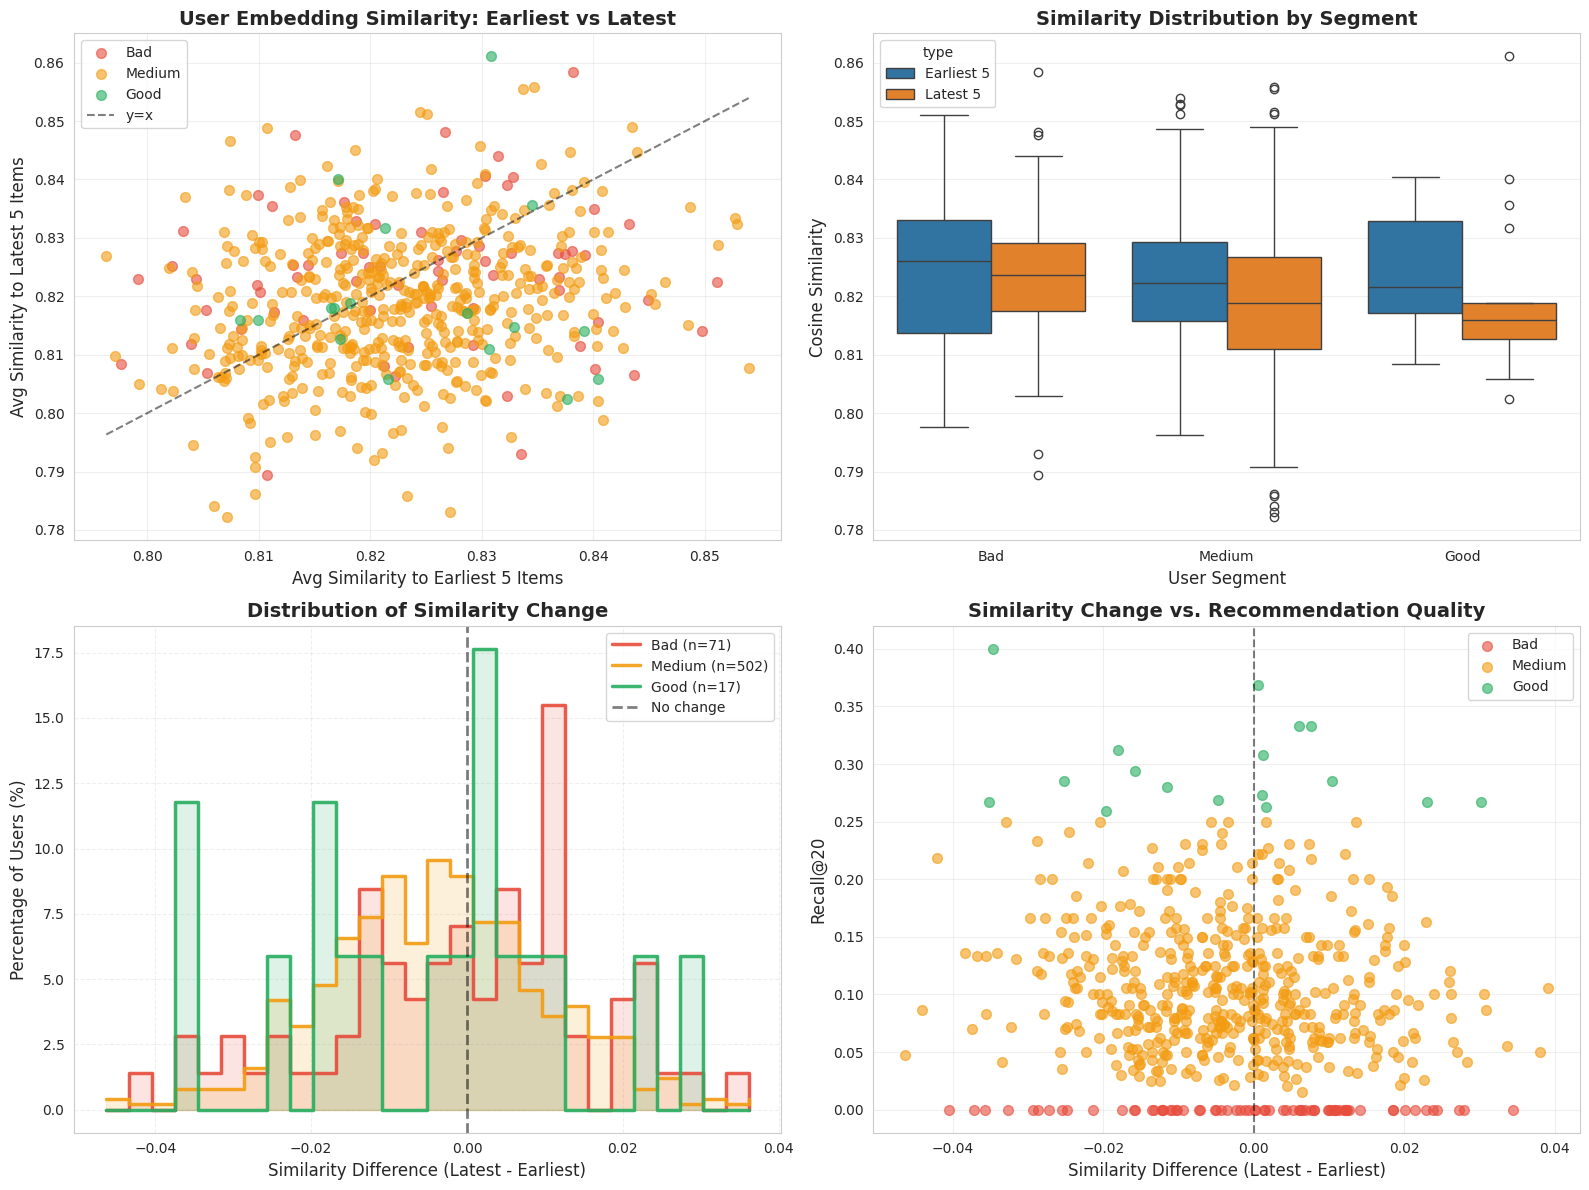

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: earliest vs latest similarities
for segment, color in zip(['Bad', 'Medium', 'Good'], colors):
    segment_data = df_sim[df_sim['segment'] == segment]
    axes[0, 0].scatter(segment_data['avg_sim_earliest_5'], segment_data['avg_sim_latest_5'],
                       alpha=0.6, c=color, label=segment, s=50)

axes[0, 0].plot([df_sim['avg_sim_earliest_5'].min(), df_sim['avg_sim_earliest_5'].max()],
                [df_sim['avg_sim_earliest_5'].min(), df_sim['avg_sim_earliest_5'].max()],
                'k--', alpha=0.5, label='y=x')
axes[0, 0].set_xlabel('Avg Similarity to Earliest 5 Items', fontsize=12)
axes[0, 0].set_ylabel('Avg Similarity to Latest 5 Items', fontsize=12)
axes[0, 0].set_title('User Embedding Similarity: Earliest vs Latest', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Box plot: similarities by segment
sim_data_melted = df_sim.melt(id_vars=['segment'], 
                               value_vars=['avg_sim_earliest_5', 'avg_sim_latest_5'],
                               var_name='type', value_name='similarity')
sim_data_melted['type'] = sim_data_melted['type'].map({
    'avg_sim_earliest_5': 'Earliest 5',
    'avg_sim_latest_5': 'Latest 5'
})

sns.boxplot(data=sim_data_melted, x='segment', y='similarity', hue='type',
            order=['Bad', 'Medium', 'Good'], ax=axes[0, 1])
axes[0, 1].set_xlabel('User Segment', fontsize=12)
axes[0, 1].set_ylabel('Cosine Similarity', fontsize=12)
axes[0, 1].set_title('Similarity Distribution by Segment', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Histogram: similarity difference
# Determine shared bins based on all data
all_sim_diff = df_sim['sim_diff']
bins = np.linspace(all_sim_diff.min(), all_sim_diff.max(), 30)

# Plot all three segments with step histograms (like cell 12)
for segment, color in zip(['Bad', 'Medium', 'Good'], colors):
    segment_data = df_sim[df_sim['segment'] == segment]['sim_diff']
    # Calculate histogram values
    counts, bin_edges = np.histogram(segment_data, bins=bins)
    # Convert to percentages
    percentages = (counts / len(segment_data)) * 100
    # Plot as step histogram (line style)
    axes[1, 0].plot(bin_edges[:-1], percentages, drawstyle='steps-post', color=color, 
                    linewidth=2.5, label=f'{segment} (n={len(segment_data)})', alpha=0.9)
    # Fill under the curve with transparency
    axes[1, 0].fill_between(bin_edges[:-1], percentages, step='post', color=color, alpha=0.15)

axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.5, label='No change')
axes[1, 0].set_xlabel('Similarity Difference (Latest - Earliest)', fontsize=12)
axes[1, 0].set_ylabel('Percentage of Users (%)', fontsize=12)
axes[1, 0].set_title('Distribution of Similarity Change', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='both', alpha=0.3, linestyle='--')

# 4. Scatter: similarity diff vs recall
for segment, color in zip(['Bad', 'Medium', 'Good'], colors):
    segment_data = df_sim[df_sim['segment'] == segment]
    axes[1, 1].scatter(segment_data['sim_diff'], segment_data['recall@20'],
                       alpha=0.6, c=color, label=segment, s=50)

axes[1, 1].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Similarity Difference (Latest - Earliest)', fontsize=12)
axes[1, 1].set_ylabel('Recall@20', fontsize=12)
axes[1, 1].set_title('Similarity Change vs. Recommendation Quality', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / f'embedding_similarity_{MODEL}_{DATASET}.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlation Analysis

Correlation Matrix:
                    recall@20   n_train  avg_sim_earliest_5  avg_sim_latest_5  \
recall@20            1.000000 -0.108499            0.022080         -0.128470   
n_train             -0.108499  1.000000           -0.090158         -0.064355   
avg_sim_earliest_5   0.022080 -0.090158            1.000000          0.179930   
avg_sim_latest_5    -0.128470 -0.064355            0.179930          1.000000   
sim_diff            -0.122800  0.011897           -0.575716          0.700716   

                    sim_diff  
recall@20          -0.122800  
n_train             0.011897  
avg_sim_earliest_5 -0.575716  
avg_sim_latest_5    0.700716  
sim_diff            1.000000  


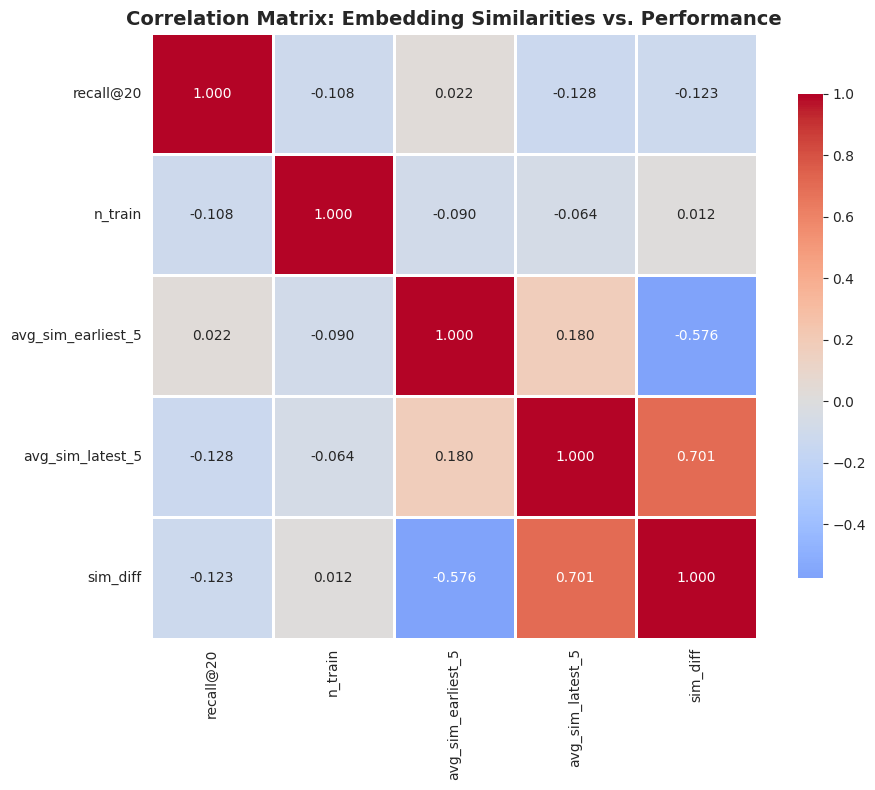

In [15]:
# Compute correlations
print("Correlation Matrix:")
corr_cols = ['recall@20', 'n_train', 'avg_sim_earliest_5', 'avg_sim_latest_5', 'sim_diff']
corr_matrix = df_sim[corr_cols].corr()
print(corr_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Embedding Similarities vs. Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / f'correlation_matrix_{MODEL}_{DATASET}.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary Statistics

In [16]:
print("\n" + "="*100)
print("ANALYSIS SUMMARY")
print("="*100)

print(f"\nDataset: {DATASET}")
print(f"Model: {MODEL}")
print(f"Total users analyzed: {len(df_recs)}")

print("\n" + "-"*100)
print("User Segmentation by Recall@20:")
print("-"*100)
for segment in ['Bad', 'Medium', 'Good']:
    seg_data = df_recs[df_recs['segment'] == segment]
    print(f"\n{segment}:")
    print(f"  Count: {len(seg_data)} ({100*len(seg_data)/len(df_recs):.1f}%)")
    print(f"  Avg train interactions: {seg_data['n_train_interactions'].mean():.1f} ± {seg_data['n_train_interactions'].std():.1f}")
    print(f"  Avg recall@20: {seg_data['recall@20'].mean():.4f} ± {seg_data['recall@20'].std():.4f}")

print("\n" + "-"*100)
print(f"Embedding Similarity Analysis (users with >={min_interactions} interactions):")
print("-"*100)
print(f"Users analyzed: {len(df_sim)} ({100*len(df_sim)/len(df_recs):.1f}% of total)")
print(f"\nOverall averages:")
print(f"  Similarity to earliest 5 items: {df_sim['avg_sim_earliest_5'].mean():.4f}")
print(f"  Similarity to latest 5 items:   {df_sim['avg_sim_latest_5'].mean():.4f}")
print(f"  Average change:                  {df_sim['sim_diff'].mean():.4f}")

# Test if there's a significant difference
from scipy import stats
t_stat, p_value = stats.ttest_rel(df_sim['avg_sim_latest_5'], df_sim['avg_sim_earliest_5'])
print(f"\nPaired t-test (latest vs earliest):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.6f}")
if p_value < 0.001:
    print(f"  Result: Highly significant difference (p < 0.001)")
elif p_value < 0.05:
    print(f"  Result: Significant difference (p < 0.05)")
else:
    print(f"  Result: No significant difference (p >= 0.05)")

print("\n" + "="*100)


ANALYSIS SUMMARY

Dataset: steam
Model: lightgcn_plus
Total users analyzed: 22345

----------------------------------------------------------------------------------------------------
User Segmentation by Recall@20:
----------------------------------------------------------------------------------------------------

Bad:
  Count: 13029 (58.3%)
  Avg train interactions: 10.8 ± 7.6
  Avg recall@20: 0.0000 ± 0.0000

Medium:
  Count: 4677 (20.9%)
  Avg train interactions: 25.1 ± 30.5
  Avg recall@20: 0.1761 ± 0.0606

Good:
  Count: 4639 (20.8%)
  Avg train interactions: 10.6 ± 6.9
  Avg recall@20: 0.5024 ± 0.2154

----------------------------------------------------------------------------------------------------
Embedding Similarity Analysis (users with >=50 interactions):
----------------------------------------------------------------------------------------------------
Users analyzed: 590 (2.6% of total)

Overall averages:
  Similarity to earliest 5 items: 0.8229
  Similarity to lates

## Export Results

In [17]:
# Save segmented data
output_file = ANALYSIS_DIR / f'user_segments_{MODEL}_{DATASET}.csv'
df_recs.to_csv(output_file, index=False)
print(f"Saved segmented user data to: {output_file}")

# Save similarity analysis
if len(df_sim) > 0:
    sim_output_file = ANALYSIS_DIR / f'embedding_similarities_{MODEL}_{DATASET}.csv'
    df_sim.to_csv(sim_output_file, index=False)
    print(f"Saved embedding similarity data to: {sim_output_file}")

print("\nAnalysis complete!")

Saved segmented user data to: analysis/steam/lightgcn_plus/user_segments_lightgcn_plus_steam.csv
Saved embedding similarity data to: analysis/steam/lightgcn_plus/embedding_similarities_lightgcn_plus_steam.csv

Analysis complete!
